This is a very early and mechanical attempt at using a few well-known ML algorithms to do classification. There is a bit of data cleaning, feature engineering, and model comparison. I try to keep it organized and contained. More to follow!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplleaflet
# sns.set_context("poster")
plt.rcdefaults()
plt.style.use('ggplot')
# np.set_printoptions(precision=2)
current_palette = sns.color_palette()
%matplotlib inline

# Exploratory Analysis & Feature Engineering

Load the data and take a look.

In [2]:
train_df = pd.read_json("train.json")
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.500000,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.714500,7211212,-73.942500,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.000000,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.794700,7150865,-73.966700,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.000000,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.738800,6887163,-74.001800,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.000000,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.753900,6888711,-73.967700,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.000000,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.824100,6934781,-73.949300,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


Drop extreme values for the numerical variables. Kudos to https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models.

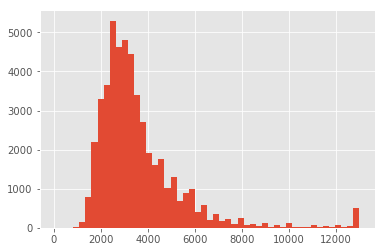

In [3]:
# treat price
price_max = np.percentile(train_df.price, 99)
train_df.loc[train_df.price > price_max, 'price'] = price_max
train_df.price.hist(bins=50)

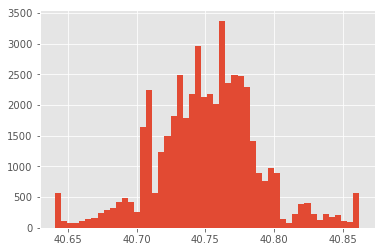

In [4]:
# treat latitude
latitude_max = np.percentile(train_df.latitude, 99)
latitude_min = np.percentile(train_df.latitude, 1)
train_df.loc[train_df.latitude > latitude_max, 'latitude'] = latitude_max
train_df.loc[train_df.latitude < latitude_min, 'latitude'] = latitude_min
train_df.latitude.hist(bins=50)

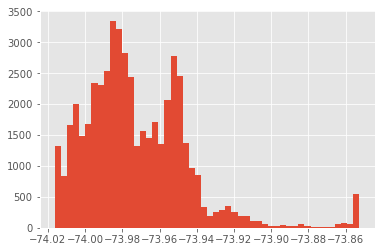

In [5]:
# treat longitude
longitude_max = np.percentile(train_df.longitude, 99)
longitude_min = np.percentile(train_df.longitude, 1)
train_df.loc[train_df.longitude > longitude_max, 'longitude'] = longitude_max
train_df.loc[train_df.longitude < longitude_min, 'longitude'] = longitude_min
train_df.longitude.hist(bins=50)

What are the pair patterns between location, price and the resultant class?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134e35048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x133e29400>]], dtype=object)

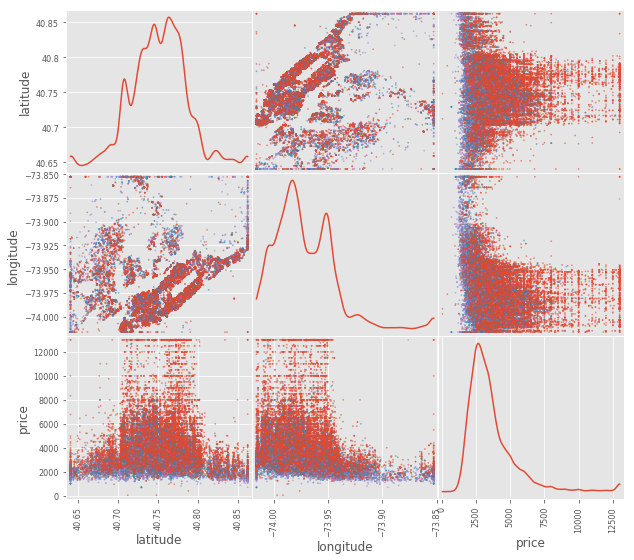

In [40]:
train_df['interest_level_coded'] = train_df.interest_level.map({'low': 0, 'medium': 1, 'high':2})
cmapping = train_df.interest_level_coded.map({i: current_palette[i] for i in [0, 1, 2]})
pd.scatter_matrix(train_df[['latitude', 'longitude', 'price']], figsize=[10, 9], s=6, c=cmapping, diagonal='kde')

In [41]:
# try seaborn pairplot but can't seem to fix the scatter overlap.
# sns.pairplot(train_df[['latitude', 'longitude', 'price', 'interest_level']], hue='interest_level', 
#              hue_order=['low', 'medium', 'high'], plot_kws=dict(s=10, alpha=0.2), markers='o', diag_kind='hist')

Now we try to subsample the training set and plot on a slippy map.

In [42]:
f = plt.figure(figsize=(10, 10))
train_df_sampled = train_df.sample(100)
plt.scatter(train_df_sampled.longitude, train_df_sampled.latitude, s=50, c=cmapping)
mplleaflet.display(fig=f)

Some feature engineering. Kudos to https://www.kaggle.com/aikinogard/two-sigma-connect-rental-listing-inquiries/random-forest-starter-with-numerical-features.

In [6]:
train_df["num_photos"] = train_df.photos.apply(len)
train_df["num_features"] = train_df.features.apply(len)
train_df["num_description_words"] = train_df.description.apply(lambda x: len(x.split(" ")))
train_df["created"] = pd.to_datetime(train_df.created)
train_df["created_year"] = train_df.created.dt.year
train_df["created_month"] = train_df.created.dt.month
train_df["created_day"] = train_df.created.dt.day

# Machine Learning

In [14]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, log_loss

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Stolen from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


X_vars = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'num_photos', 'num_features', 'num_description_words', 'created_year', 'created_month', 'created_day']
X_train, X_test, y_train, y_test = train_test_split(train_df[X_vars], train_df['interest_level'], stratify= train_df['interest_level'])

## Logistic Regression

### LogisticRegressionCV

Let's first fit `LogisticRegressionCV` (built-in CV).

In [45]:
Cs = np.logspace(-3, 1, 10)
lrcv = LogisticRegressionCV(Cs=Cs, scoring='neg_log_loss').fit(X_train, y_train)

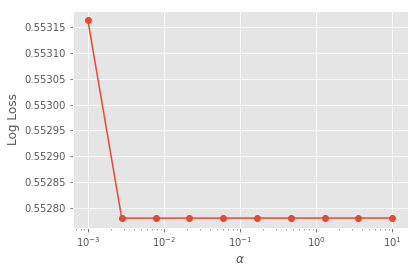

In [46]:
# scores correspond to three interest levels. low has the largest log loss
plt.semilogx(lrcv.Cs_, -lrcv.scores_['low'].mean(axis=0), '-o')
# plt.semilogx(lrcv.Cs_, -(lrcv.scores_['low'] + lrcv.scores_['medium'] + lrcv.scores_['high']).mean(axis=0)/3, '-o')
plt.xlabel(r'$\alpha$')
plt.ylabel('Log Loss')

             precision    recall  f1-score   support

       high       0.00      0.00      0.00       960
        low       0.70      0.98      0.82      8571
     medium       0.30      0.05      0.08      2807

avg / total       0.56      0.69      0.59     12338

Normalized confusion matrix
[[ 0.    0.9   0.1 ]
 [ 0.    0.98  0.02]
 [ 0.    0.95  0.05]]


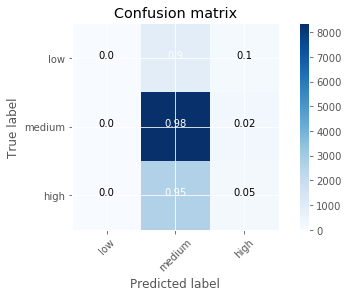

In [47]:
y_pred = lrcv.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['low', 'medium', 'high'], normalize=True)

### LogisticRegression

Next we try `LogisticRegression` with the slower `GridSearchCV`.

In [48]:
lr = GridSearchCV(LogisticRegression(), {'C': Cs}, scoring='neg_log_loss').fit(X_train, y_train)

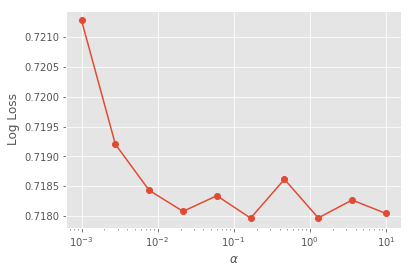

In [49]:
lr_cv_results = pd.DataFrame(lr.cv_results_)
plt.semilogx(lr_cv_results['param_C'], -lr_cv_results['mean_test_score'], '-o')
plt.xlabel(r'$\alpha$')
plt.ylabel('Log Loss')

In [ ]:
print(lr.best_params_, lr.best_score_)

             precision    recall  f1-score   support

       high       0.25      0.00      0.00       960
        low       0.70      0.98      0.82      8571
     medium       0.29      0.03      0.06      2807

avg / total       0.57      0.69      0.58     12338

Normalized confusion matrix
[[ 0.    0.92  0.08]
 [ 0.    0.98  0.02]
 [ 0.    0.97  0.03]]


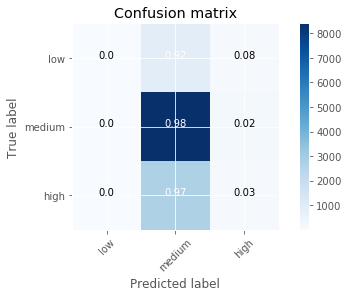

In [50]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['low', 'medium', 'high'], normalize=True)

They yield similar results.

## Support Vector Machine

SVM doesn't like big data. Let's subsample and get an idea.

In [ ]:
X_train_sample, y_train_sample = X_train.iloc[:5000], y_train.iloc[:5000]

### LinearSVC

First do a `LinearSVC` with a linear kernel. It doesn't support getting probability output.

In [8]:
svc_lin = GridSearchCV(LinearSVC(multi_class='ovr'),
                       {'C': np.logspace(-2, 10, 10)}).fit(X_train_sample, y_train_sample)

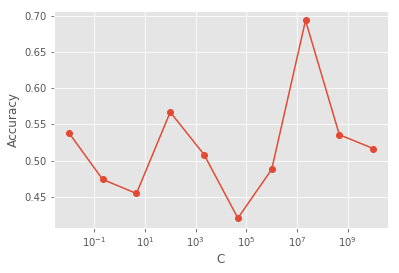

In [21]:
svc_lin_cv_results = pd.DataFrame(svc_lin.cv_results_)
plt.semilogx(svc_lin_cv_results['param_C'], svc_lin_cv_results['mean_test_score'], '-o')
plt.xlabel('C')
plt.ylabel('Accuracy')

In [ ]:
print(svc_lin.best_params_, svc_lin.best_score_)

             precision    recall  f1-score   support

       high       0.38      0.17      0.24       960
        low       0.71      0.98      0.82      8571
     medium       0.67      0.00      0.00      2807

avg / total       0.67      0.70      0.59     12338

Confusion matrix, without normalization
[[ 164  796    0]
 [ 147 8423    1]
 [ 124 2681    2]]


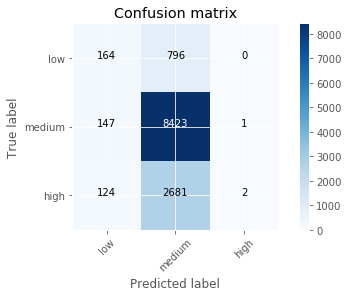

In [15]:
y_pred = svc_lin.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['low', 'medium', 'high'])

### SVC

Now try `SVC` with the rbf kernel. Getting probabilities requires too many resources. Switch it off and use the default scoring method to do CV.

In [17]:
svc_rbf = GridSearchCV(SVC(kernel='rbf', decision_function_shape='ovr'), 
                       {'C': np.logspace(-2, 10, 3), 'gamma': np.logspace(-9, 3, 3)}
                      ).fit(X_train_sample, y_train_sample)

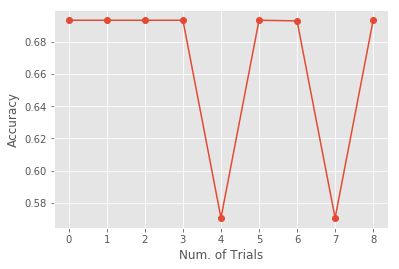

In [33]:
svc_rbf_cv_results = pd.DataFrame(svc_rbf.cv_results_)
plt.plot(svc_rbf_cv_results['mean_test_score'], '-o')
plt.xlabel('Num. of Trials')
plt.ylabel('Accuracy')

In [24]:
print(svc_rbf.best_params_, svc_rbf.best_score_)

{'gamma': 1.0000000000000001e-09, 'C': 0.01} 0.6934


/Applications/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

       high       0.00      0.00      0.00       960
        low       0.69      1.00      0.82      8571
     medium       0.00      0.00      0.00      2807

avg / total       0.48      0.69      0.57     12338

Normalized confusion matrix
[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


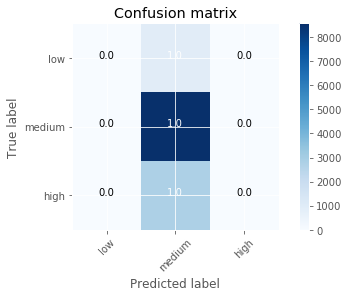

In [29]:
y_pred = svc_rbf.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['low', 'medium', 'high'], normalize=True)

This is not as good as the simple linear kernel. But it is also likely that we did not try too many points.

## Ensemble Methods

### RandomForestClassifier

Try `RandomForestClassifier`. First we use the internal OOB validation.

In [51]:
n_estimators = np.logspace(1, 3, 5).astype(int)
scores = []
for i in n_estimators:
    rf = RandomForestClassifier(n_estimators=i, oob_score=True, n_jobs=-1).fit(X_train, y_train)
    scores.append(rf.oob_score_)

/Applications/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Applications/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


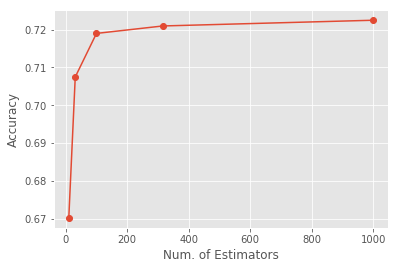

In [52]:
plt.plot(n_estimators, scores, '-o')
plt.xlabel('Num. of Estimators')
plt.ylabel('Accuracy') # this is not log loss!

Now use `GridSearchCV` because internal OOB can't do log loss.

In [53]:
rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), {'n_estimators': n_estimators},
                 scoring='neg_log_loss').fit(X_train, y_train)

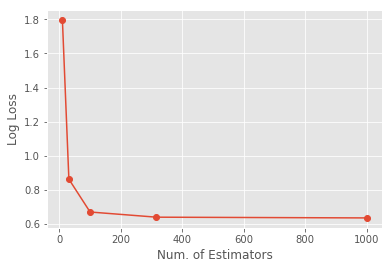

In [54]:
rf_cv_results = pd.DataFrame(rf.cv_results_)
plt.plot(rf_cv_results['param_n_estimators'], -rf_cv_results['mean_test_score'], '-o')
plt.xlabel('Num. of Estimators')
plt.ylabel('Log Loss')

In [ ]:
print(rf.best_params_, rf.best_score_)

             precision    recall  f1-score   support

       high       0.51      0.22      0.30       960
        low       0.77      0.93      0.84      8571
     medium       0.46      0.27      0.34      2807

avg / total       0.68      0.72      0.69     12338

Normalized confusion matrix
[[ 0.22  0.44  0.34]
 [ 0.01  0.93  0.06]
 [ 0.05  0.68  0.27]]


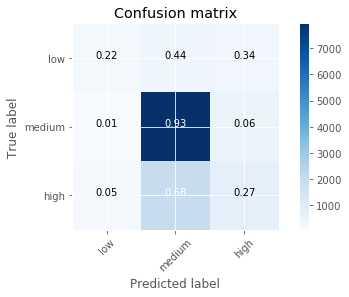

In [55]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['low', 'medium', 'high'], normalize=True)

Compared with logistic regression, it fares better.

### GradientBoostingClassifier

Try `GradientBoostingClassifier`.

In [30]:
params = {'learning_rate': [0.05, 0.1, 0.2], 'subsample': [1, 0.5]}
gbc = GridSearchCV(GradientBoostingClassifier(n_estimators=1000), 
                         params, scoring='neg_log_loss').fit(X_train, y_train)

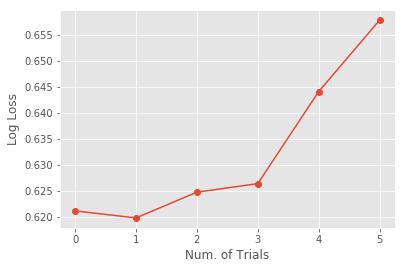

In [34]:
gbc_cv_results = pd.DataFrame(gbc.cv_results_)
plt.plot(-gbc_cv_results['mean_test_score'], '-o')
plt.xlabel('Num. of Trials')
plt.ylabel('Log Loss')

In [37]:
print(gbc.best_params_, gbc.best_score_)

{'learning_rate': 0.05, 'subsample': 0.5} -0.619733674285


             precision    recall  f1-score   support

       high       0.55      0.20      0.29       960
        low       0.77      0.93      0.84      8571
     medium       0.47      0.28      0.35      2807

avg / total       0.69      0.73      0.69     12338

Normalized confusion matrix
[[ 0.2   0.42  0.38]
 [ 0.01  0.93  0.06]
 [ 0.03  0.69  0.28]]


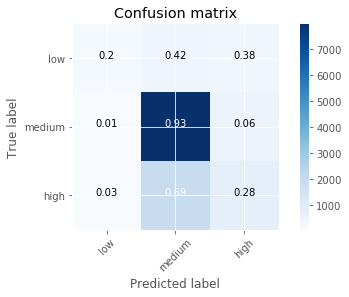

In [35]:
y_pred = gbc.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['low', 'medium', 'high'], normalize=True)

## Submission

This is so far the best model. Let's use it to predict the actual test set.

In [39]:
test_df = pd.read_json("test.json")
test_df["num_photos"] = test_df.photos.apply(len)
test_df["num_features"] = test_df.features.apply(len)
test_df["num_description_words"] = test_df.description.apply(lambda x: len(x.split(" ")))
test_df["created"] = pd.to_datetime(test_df.created)
test_df["created_year"] = test_df.created.dt.year
test_df["created_month"] = test_df.created.dt.month
test_df["created_day"] = test_df.created.dt.day

y = gbc.predict_proba(test_df[X_vars])

In [46]:
labels2idx = {label: i for i, label in enumerate(gbc.best_estimator_.classes_)}
y_df = pd.DataFrame()
y_df["listing_id"] = test_df["listing_id"]
for label in ["high", "medium", "low"]:
    y_df[label] = y[:, labels2idx[label]]
y_df.to_csv("submission_gbc.csv", index=False)